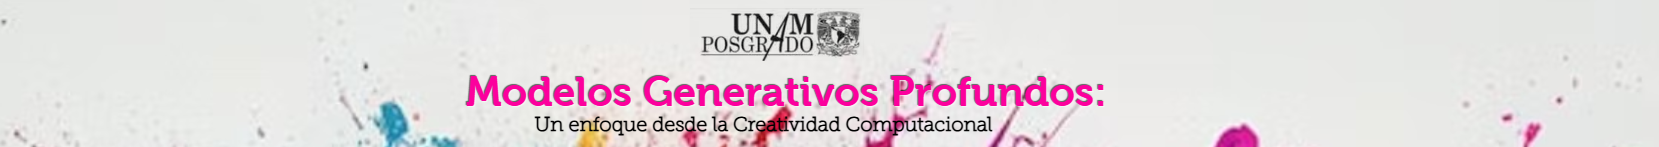

# Interpolación en el espacio latente  
### como una estrategias de control generativo en VAEs usando CelebA Faces

En este cuaderno exploraremos la interpolación en el espacio latente como una estrategia de control generativo en autoencoders variacionales (VAEs), utilizando el dataset CelebA Faces como caso de estudio.

In [ ]:
import os
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 128
BUFFER_SIZE = 1000

## 1. Cargar los modelos del VAE ya entrenado con CelebA Faces

In [ ]:
# Cargaremos los modelos desde Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==============================================================
# NOTA IMPORTANTE:
# En el VAE necesitamos una capa personalizada llamada "Sampling",
# que implementa el truco de reparametrización:
#        z = mean + exp(log_var / 2) * epsilon
#
# Keras no incluye esta capa de forma nativa. Cuando guardamos y
# cargamos un modelo que la usa, Keras solo guarda una referencia
# con el nombre "Sampling", pero no el código de la clase.
#
# Por eso debemos volver a definirla aquí antes de cargar el encoder
# entrenado, para que Keras pueda reconstruir correctamente el modelo.
# ==============================================================

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
# Modelos del autocodificador variacional
drive_path = "/content/drive/My Drive/Colab Notebooks/CursoIAGenerativa/notebooks/Clase11_autoencoders_II"

encoder_variacional = keras.models.load_model(
    os.path.join(drive_path, "vae_encoder_faces.keras"),
    custom_objects={"Sampling": Sampling}
)
decoder_variacional = keras.models.load_model(os.path.join(drive_path, "vae_decoder_faces.keras"))

## 3. Dercargar el dataset CelebA faces y pre-procesar las imágenes

In [ ]:
print("Descargando CelebA (esto puede tardar unos minutos la primera vez)...")
x_test = tfds.load("celeb_a", split="test")


Descargando CelebA (esto puede tardar unos minutos la primera vez)...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/incomplete.1ECVGS_2.1.0/celeb_a-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/incomplete.1ECVGS_2.1.0/celeb_a-validation.tfrecord*...:   0%|    …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/celeb_a/incomplete.1ECVGS_2.1.0/celeb_a-test.tfrecord*...:   0%|          …

Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.1.0. Subsequent calls will reuse this data.


In [ ]:
def preprocess(example):
    img = example["image"]
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))  # Redimensionar
    img = tf.cast(img, tf.float32) / 255.0                # Normalizar a [0,1]
    return img

# Aplicar preprocesamiento, mezclar, agrupar en batches
test = x_test.map(preprocess).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

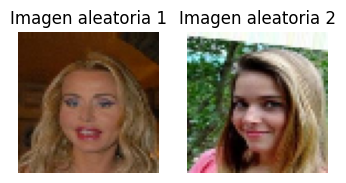

In [ ]:
# Tomar un batch del dataset (ej. 128 imágenes de 64x64x3)
batch = next(iter(test)) # batch es un tensor de imágenes

# Asegurarse de que sea numpy
if isinstance(batch, tf.Tensor):
    batch = batch.numpy()

# Seleccionar dos ejemplos al azar
indices = np.random.choice(batch.shape[0], 2, replace=False)
img1, img2 = batch[indices]

# Mostrar imágenes
plt.figure(figsize=(4, 2))

plt.subplot(1, 2, 1)
plt.imshow(np.clip(img1, 0, 1))  # aseguramos rango válido
plt.title("Imagen aleatoria 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(np.clip(img2, 0, 1))
plt.title("Imagen aleatoria 2")
plt.axis("off")

plt.show()



# 4. Interpolación en el espacio latente

###4.1 Seleccionar dos imágenes aleatorias

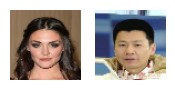

In [ ]:
# Tomar un batch de imágenes del dataset preprocesado (ej. 128 imágenes)
batch = next(iter(test))

# Convertir a numpy si es tensor
if isinstance(batch, tf.Tensor):
    batch = batch.numpy()

# Seleccionar dos ejemplos al azar
indices = np.random.choice(batch.shape[0], 2, replace=False)
img1, img2 = batch[indices]

# Mostrar imágenes
plt.figure(figsize=(2, 1))

plt.subplot(1, 2, 1)
plt.imshow(np.clip(img1, 0, 1))   # son RGB, no hace falta .squeeze() ni cmap
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(np.clip(img2, 0, 1))
plt.axis("off")

plt.show()


### 4.1 Interpolación con el VAE

In [ ]:
import gradio as gr
import numpy as np
import cv2

# Codificar dos imágenes de prueba (img1, img2 del paso anterior)
z_mean1, z_log_var1, z1 = encoder_variacional.predict(np.expand_dims(img1, 0))
z_mean2, z_log_var2, z2 = encoder_variacional.predict(np.expand_dims(img2, 0))

# Usamos z_mean como punto representativo en el espacio latente
z1 = z_mean1
z2 = z_mean2

# Decodificar extremos
recon1 = decoder_variacional.predict(z1)[0]
recon2 = decoder_variacional.predict(z2)[0]

# Convertir a uint8 (manteniendo RGB y tamaño original del decoder, ej. 64x64)
recon1 = (recon1 * 255).astype(np.uint8)
recon2 = (recon2 * 255).astype(np.uint8)

def interpolate(alpha):
    """Interpolación lineal entre z1 y z2 en VAE """
    z_interp = (1 - alpha) * z1 + alpha * z2
    recon_mid = decoder_variacional.predict(z_interp)[0]
    recon_mid = (recon_mid * 255).astype(np.uint8)
    return recon1, recon_mid, recon2

with gr.Blocks() as demo:
    gr.Markdown("### Interpolación latente entre dos rostros de CelebA usando un VAE")
    slider = gr.Slider(0, 1, value=0.5, step=0.05, label="Interpolación (α)")

    with gr.Row():
        out1 = gr.Image(type="numpy", label="Imagen 1", width=128, height=128)
        out2 = gr.Image(type="numpy", label="Interpolación", width=128, height=128)
        out3 = gr.Image(type="numpy", label="Imagen 2", width=128, height=128)

    demo.load(
        fn=interpolate,
        inputs=[slider],
        outputs=[out1, out2, out3],
        queue=False
    )

    slider.change(fn=interpolate, inputs=slider, outputs=[out1, out2, out3])

demo.launch()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2cf77232fe1ddc9ba5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
